**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

In [1]:
import numpy as np
import pandas as pd

In [2]:
import gc # сборщик мусора
import datetime # для работы со времнем
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor

import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# клакстеризация
from sklearn.cluster import KMeans

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [102]:
DATASET_PATH = 'course_project_train.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [5]:
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000163A78250F0>,
      dtype=object)

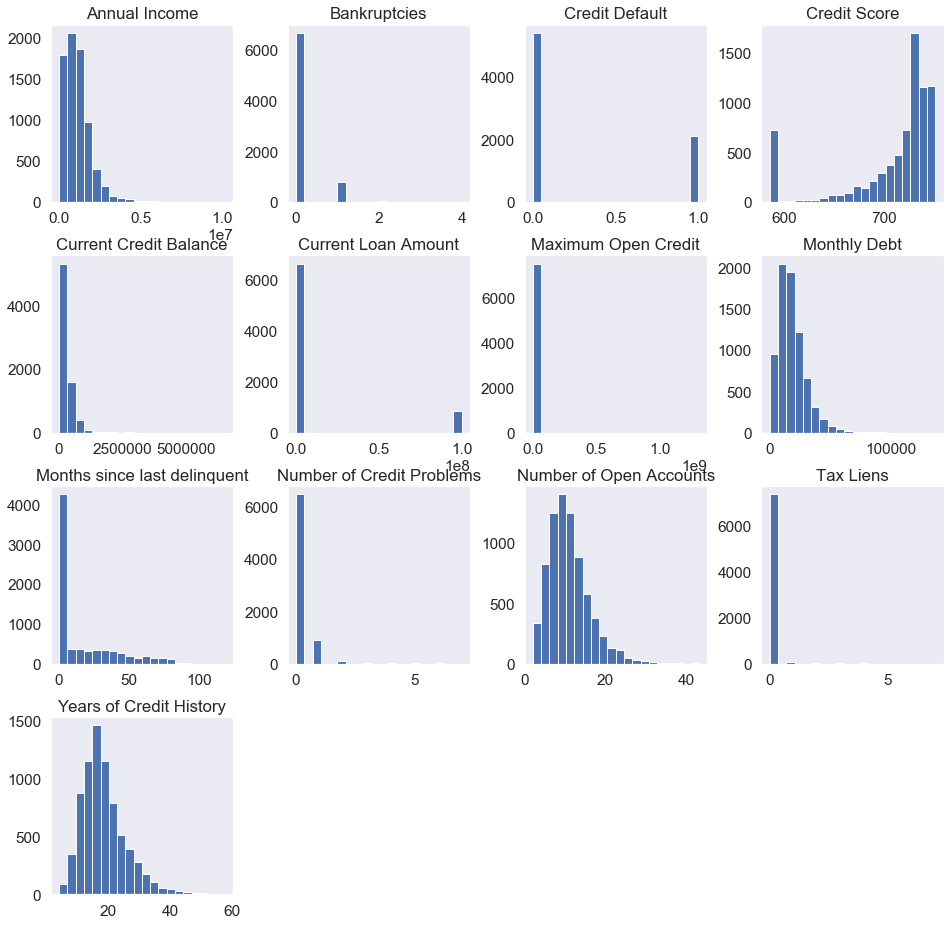

In [28]:
df.hist(figsize=(16,16), bins=20, grid=False)

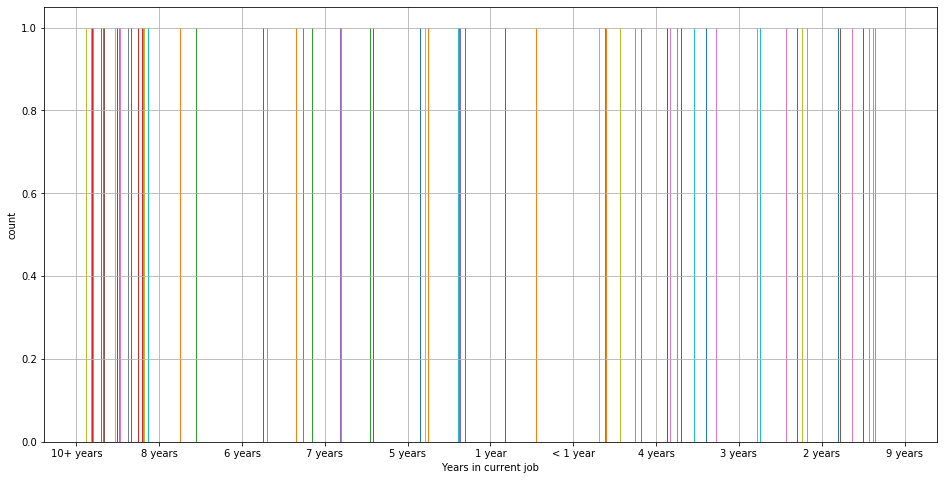

In [7]:
plt.figure(figsize = (16, 8))

df['Years in current job'].hist()  # density=True  # shift + Tab = спарвка по функции
plt.ylabel('count')
plt.xlabel('Years in current job')
plt.show()

In [8]:
TARGET_NAME = 'Credit Default'

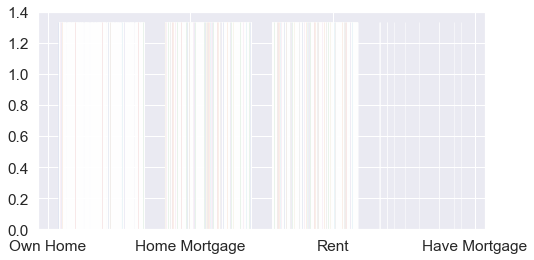

In [135]:
plt.figure(figsize=(8, 4))
plt.hist(df['Home Ownership'], bins = 4, density=True, alpha=0.5)
plt.show()

In [13]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [14]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [103]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mins = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df.median()
        self.mins = df.min()

#         self.roomsquare_median = df['Square'].median()/df['Rooms'].median()
#         self.ls_s_median = df['LifeSquare'].median()/df['Square'].median()
#         self.ks_s_median = df['KitchenSquare'].median()/df['Square'].median()
        
    def transform(self, df):
        """Трансформация данных"""

        # Исправляем выбросы по Credit Score - очевидно что там лишний ноль дописали 
        df.loc[(df['Credit Score']>850),'Credit Score'] = df['Credit Score']/10
        
        # Вместо Nan в "Months since last delinquent" ставим 0, так как логично допустить что когда нет просрочемк то и не вводили
        
        df.loc[(df['Months since last delinquent'].isnull()),'Months since last delinquent'] = 0
        
        # Аналогично по банкротствам
        df.loc[(df['Bankruptcies'].isnull()),'Bankruptcies'] = 0
        
        # Правим Credit Score и Annual Income у них Nan одновременно, что логично если не завели средний годовой доход то Credit Score не считается
        # Если количество месяцев просрочки меньше 1 и Years in current job не Null:
       
        df.loc[(df['Credit Score'].isnull()) & (df['Years in current job'].notnull()) &\
               (df['Months since last delinquent'] < 1),'Annual Income'] = df['Monthly Debt']*12
        
        df.loc[(df['Credit Score'].isnull()) & (df['Years in current job'].notnull()) &\
               (df['Months since last delinquent'] < 1),'Credit Score'] = self.medians['Credit Score']
        # Если количество месяцев просрочки больше 0 :
        df.loc[(df['Credit Score'].isnull()),['Annual Income','Credit Score']] = [0,self.mins['Credit Score']]
        
        # Правим Years in current job как меньшее из значений
        df.loc[(df['Years in current job'].isnull()),'Years in current job'] = '< 1 year'
        
        # Есть выбросы в Current Loan Amount ( = 99999999.0),но данная величина очень хорошо коррелирует с Credit Default = 0, 
        # так что оставим как есть
        # но оценив этот признак в разрезе целевой переменной получается что лучше переопределить этот показатель на 100 000
        df.loc[df['Current Loan Amount']> 1000000,'Current Loan Amount'] = 100000
       
        return df


In [104]:
pipe = DataPipeline()
pipe.fit(df) # расчет статистик
df = pipe.transform(df)

In [105]:
df.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [18]:
# df.loc[(df['Credit Score']>850),'Credit Score'] = df['Credit Score']/10
# df.loc[(df['Months since last delinquent'].isnull()),'Months since last delinquent'] = 0
# df.loc[(df['Bankruptcies'].isnull()),'Bankruptcies'] = 0
# df.loc[(df['Credit Score'].isnull()),['Annual Income','Credit Score']] = [0,df['Credit Score'].min()]
# df.loc[(df['Years in current job'].isnull()),'Years in current job'] = '< 1 year'

In [115]:
DATASET_PATH = 'course_project_test.csv'
df1 = pd.read_csv(DATASET_PATH)
df1.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [121]:
#pipe.fit(df1) # расчет статистик
df1 = pipe.transform(df1)

In [122]:
df1.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [23]:
df.loc[(df['Current Loan Amount'] > 1000000) & (df['Credit Default'] == 1)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [26]:
df.loc[df['Current Credit Balance'] > 1000000,'Current Credit Balance'].count()

188

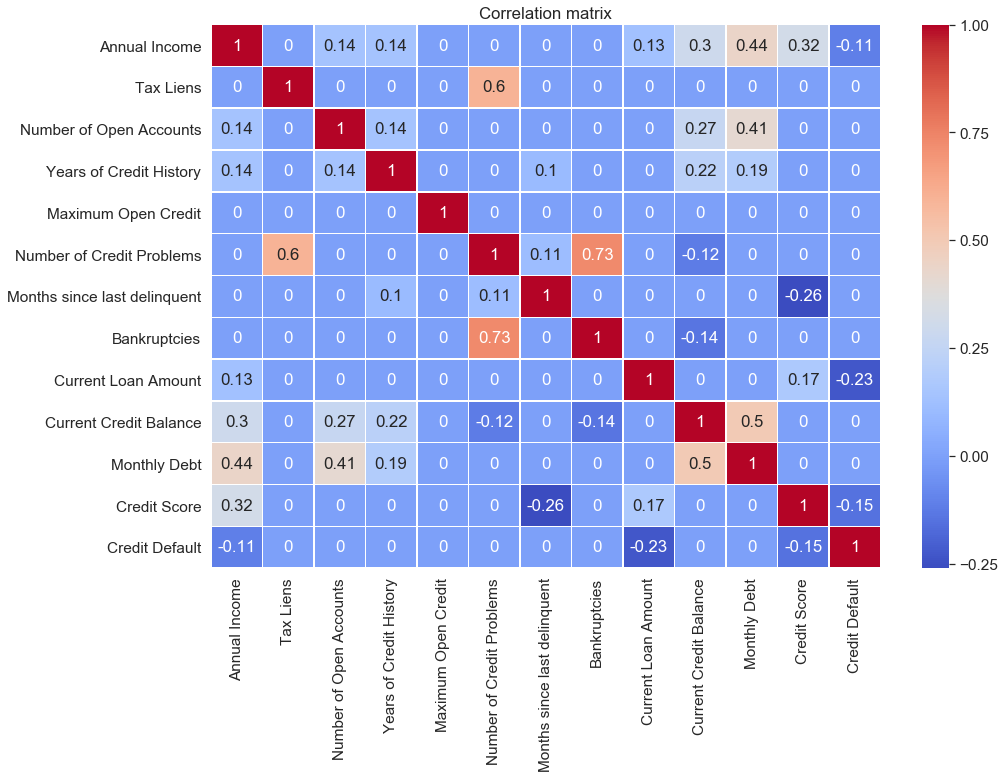

In [27]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

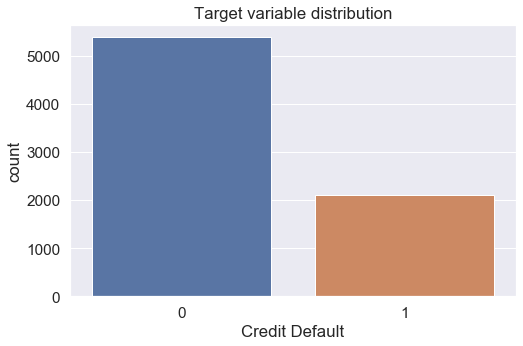

In [29]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

In [31]:
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

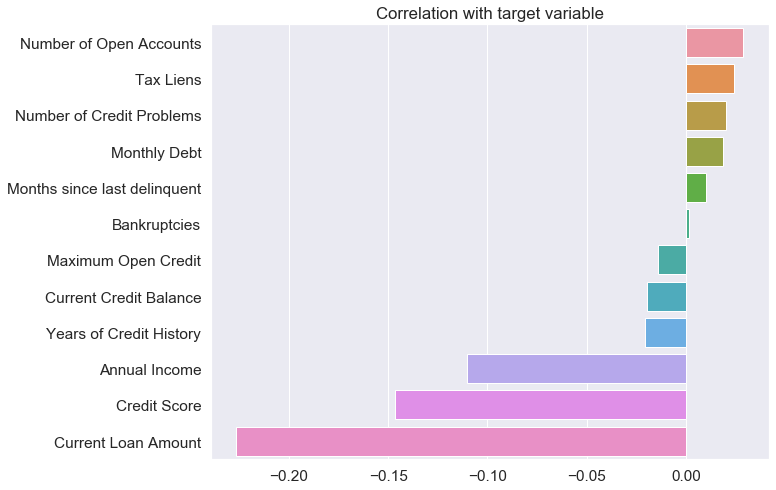

In [32]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

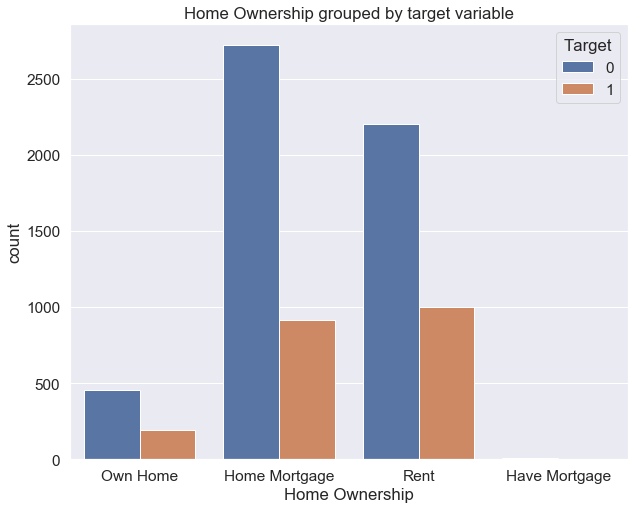

In [33]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

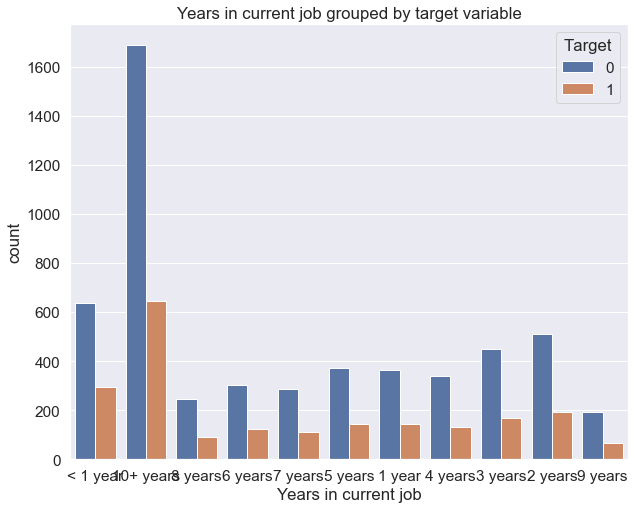

In [34]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [67]:
def countplot(df,vname,tname = TARGET_NAME):
    
    plt.figure(figsize=(10, 8))

    sns.countplot(x=vname, hue=TARGET_NAME, data=df)
    plt.title(f'{vname} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

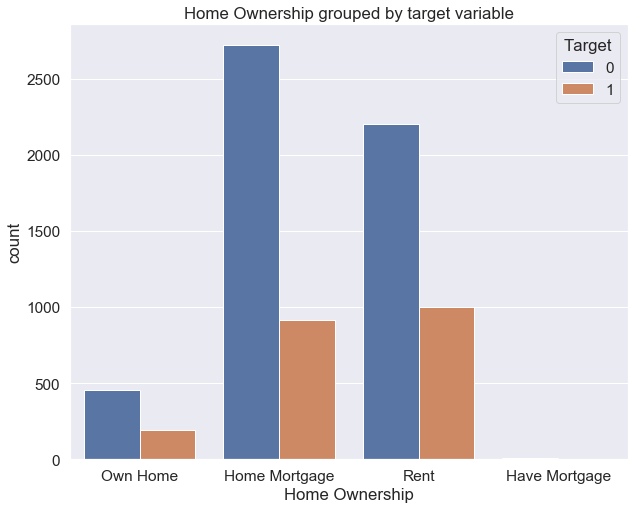

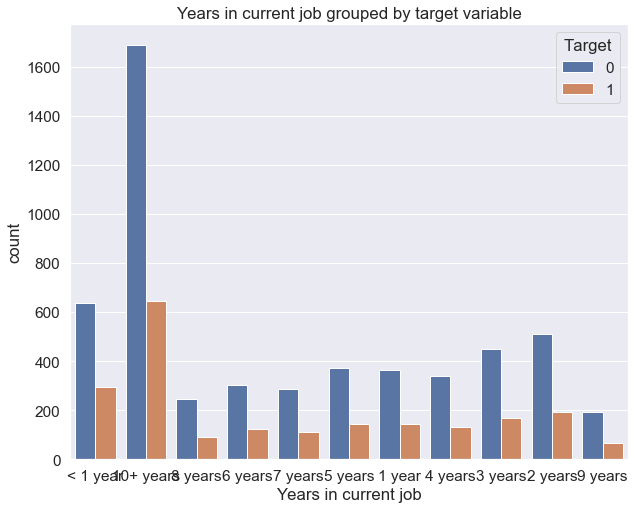

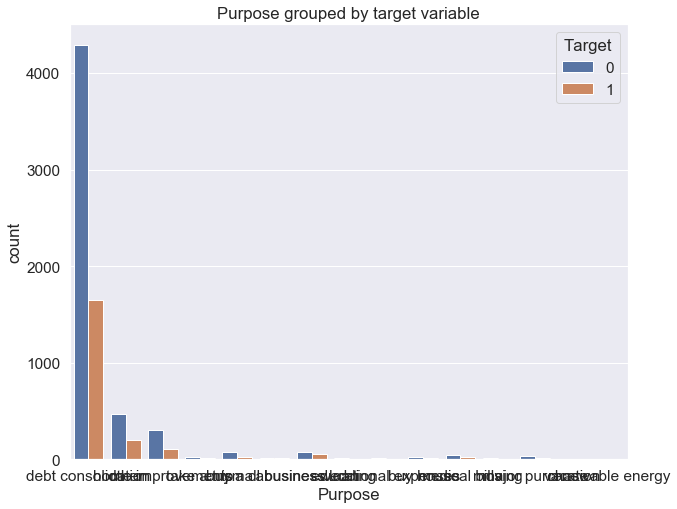

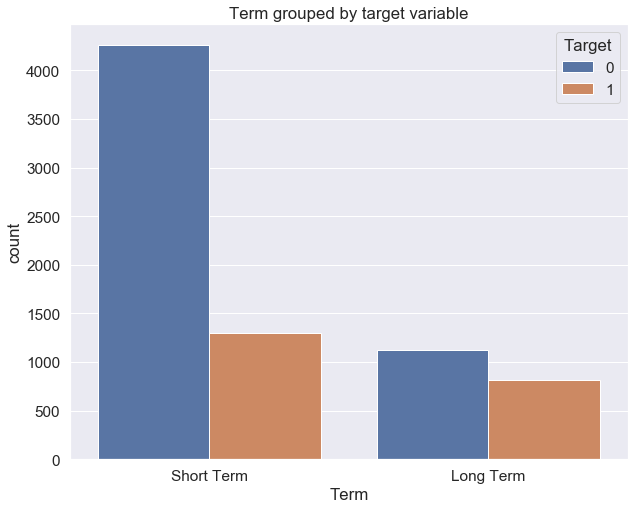

In [68]:
for vname in CAT_FEATURES:
    countplot(df,vname)

In [36]:
def plot_by_target(df,vname,tname):
    X = df[[vname, tname]]
    X_0 = X.loc[X[tname]==0,vname]
    X_1 = X.loc[X[tname]==1,vname]
    
    plt.figure(figsize=(10, 5))

    sns.kdeplot(X_0, shade=True, label='No default', color='g')
    sns.kdeplot(X_1, shade=True, label='Default', color='r')

    plt.xlabel(f'{vname}')
    plt.title(f'{vname} grouped by target variable')
    plt.show()


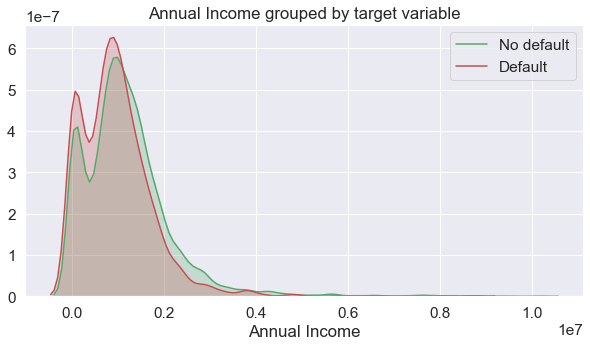

In [37]:
plot_by_target(df,'Annual Income',TARGET_NAME)

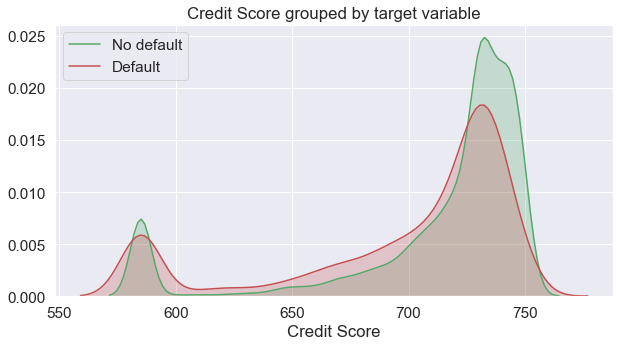

In [39]:
plot_by_target(df,'Credit Score',TARGET_NAME)

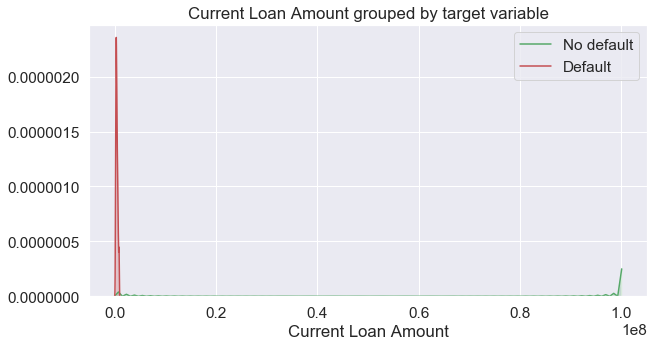

In [40]:
plot_by_target(df,'Current Loan Amount',TARGET_NAME)

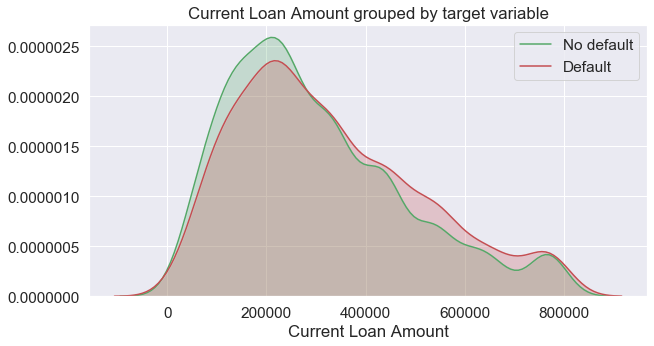

In [41]:
plot_by_target(df[df['Current Loan Amount']<1000000],'Current Loan Amount',TARGET_NAME)

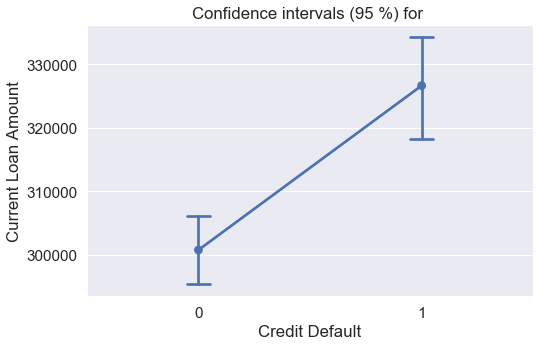

In [45]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=df[df['Current Loan Amount']<1000000], capsize=.1)

plt.title('Confidence intervals (95 %) for ')
plt.show()

In [49]:
df.loc[df['Current Loan Amount'] > 1000000,'Current Loan Amount'] = 100000

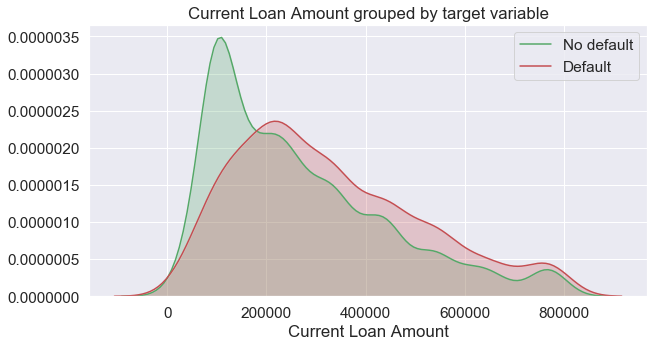

In [50]:
plot_by_target(df,'Current Loan Amount',TARGET_NAME)

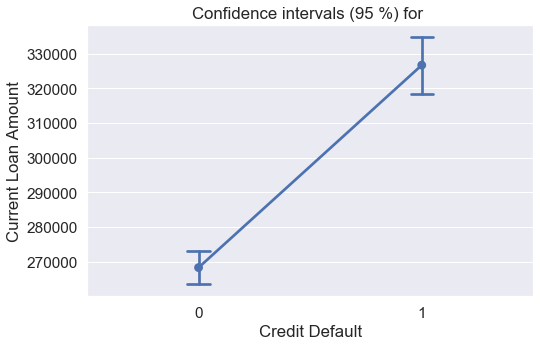

In [51]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=df, capsize=.1)

plt.title('Confidence intervals (95 %) for ')
plt.show()

In [54]:
df.select_dtypes(include='object')
CAT_FEATURES = df.select_dtypes(include='object').columns.tolist()
CAT_FEATURES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [63]:
NUM_FEATURES = df.columns.drop(CAT_FEATURES +[TARGET_NAME]).tolist()
NUM_FEATURES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

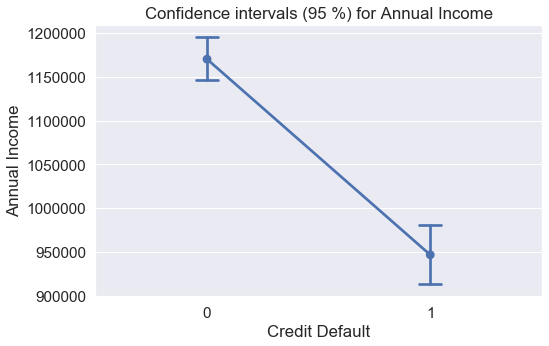

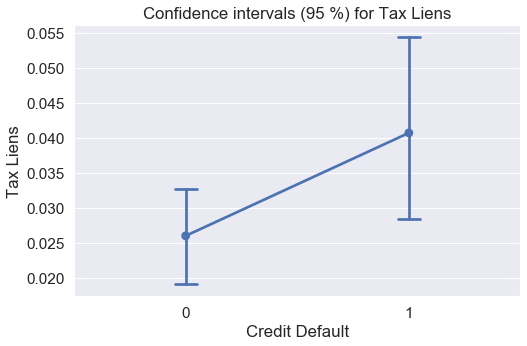

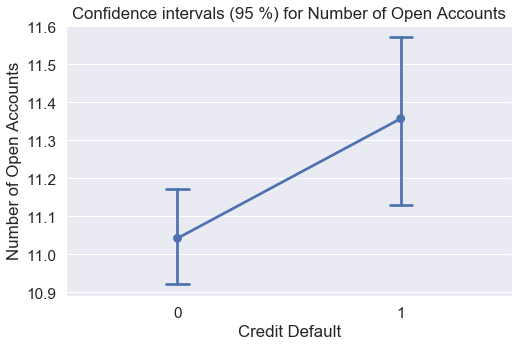

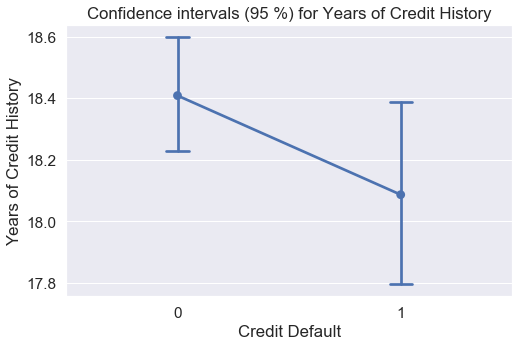

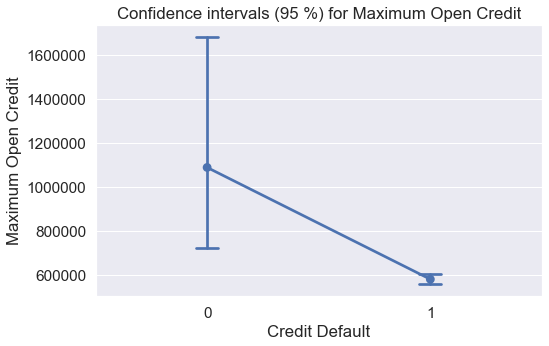

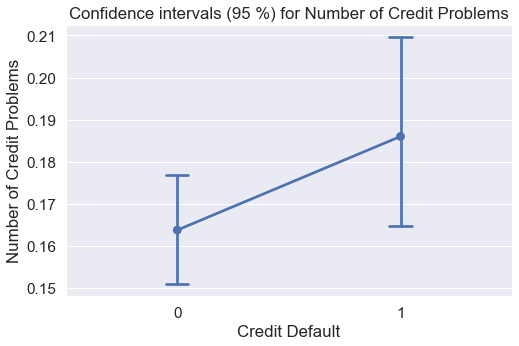

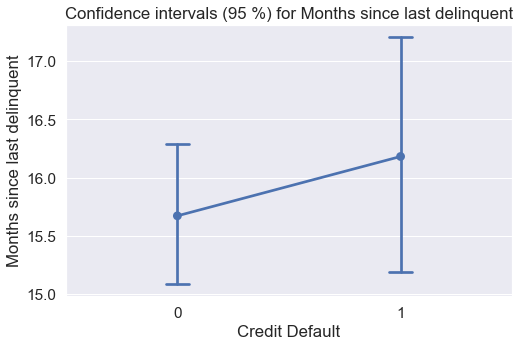

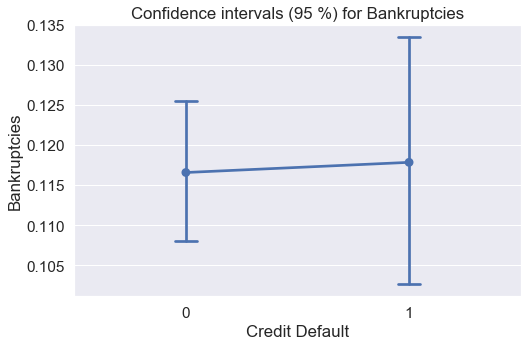

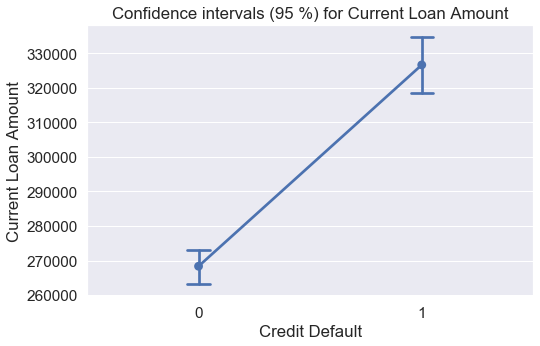

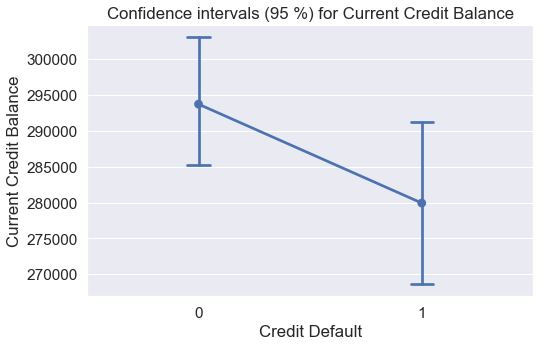

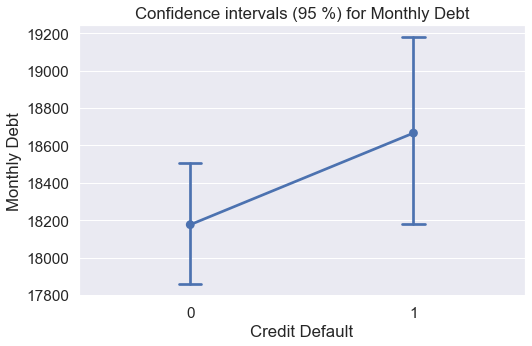

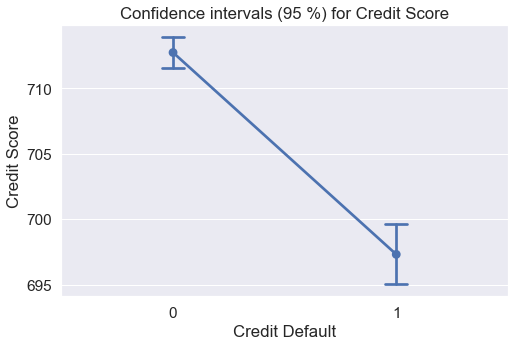

In [64]:
for vname in NUM_FEATURES:
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=TARGET_NAME, y=vname, data=df, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {vname}')
    plt.show()

Построив доверительные интервалы для средних значений, каждой из двух групп по целевой переменной и сравнимв их, получаем что: параметры: 'Annual Income','Maximum Open Credit', 'Maximum Open Credit','Current Loan Amount','Credit Score' имеют различные распределения (у них даже доверительные интервалы не пересекаются) и эти признаки может быть полезен для определения значения целевой переменной.
Остальные параметры хотя средние величины и отличаются но имеют пересекающиеся области доверительных интеравалов, что говорит о более слабом характере влияния этих параметров на целевую переменную.
А у параметра  'Bankruptcies'даже средняя величина мало отличается (что может быть еще связано с тем что очень большой перекос по количеству отличных от 0 значений)

-------
Проведем оценку распределений для тестового и тренировочного наборов

In [130]:
X_train = df.drop(TARGET_NAME,axis = 1)


In [131]:
X_train['db'] = 'train'

In [132]:
X_test = df1
X_test['db'] = 'test'
X_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,db
0,Rent,0.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,585.0,test
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,test
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,test
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,test
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,test


In [133]:
X = pd.concat([X_train,X_test])

In [134]:
X.shape

(10000, 17)

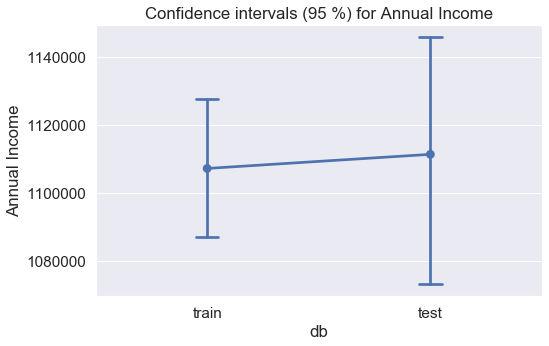

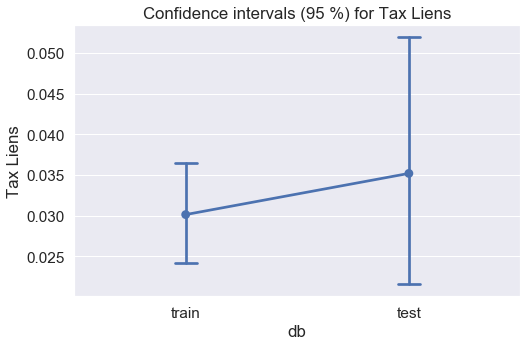

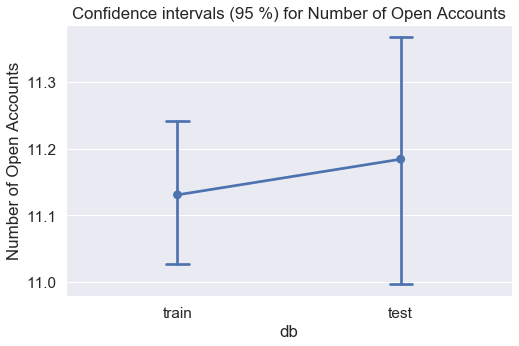

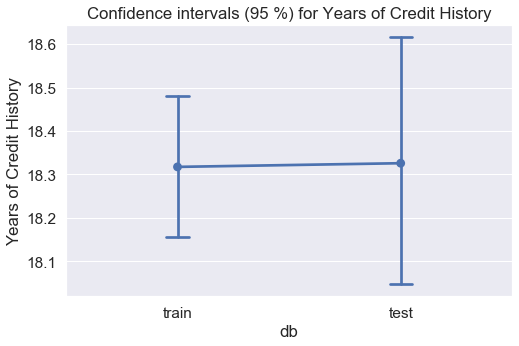

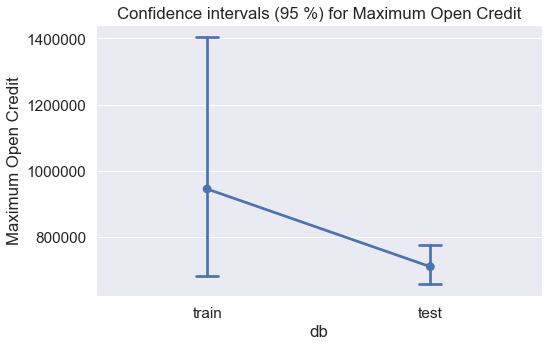

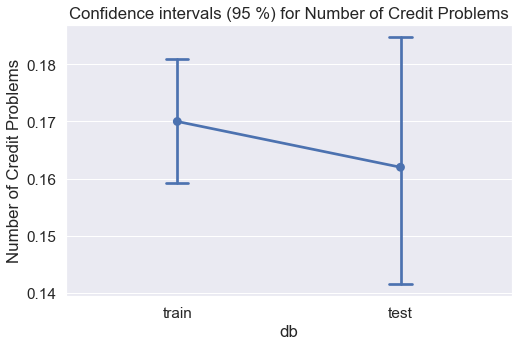

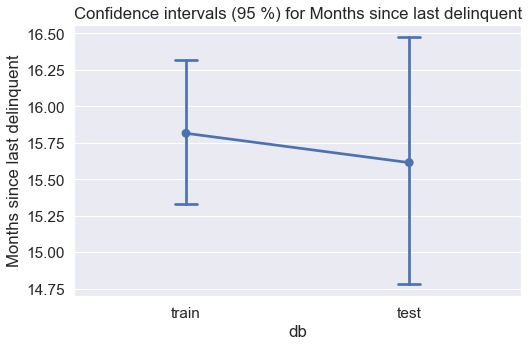

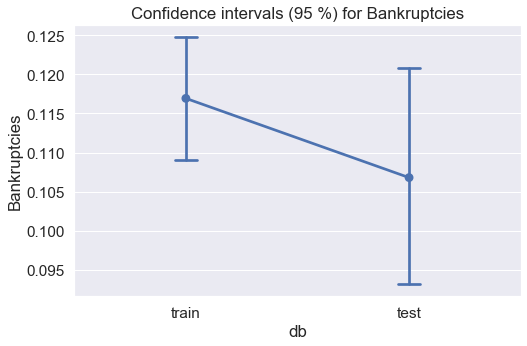

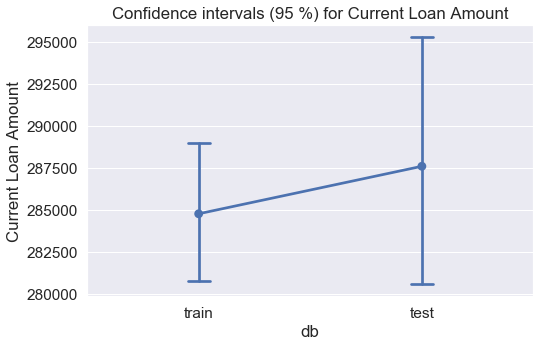

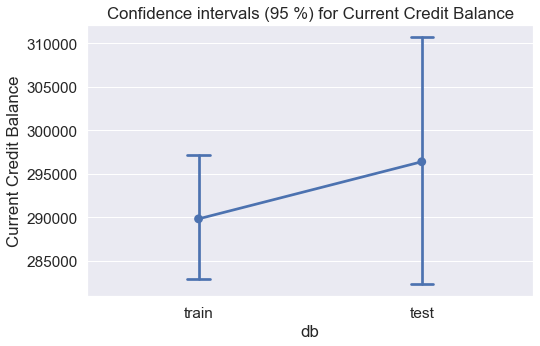

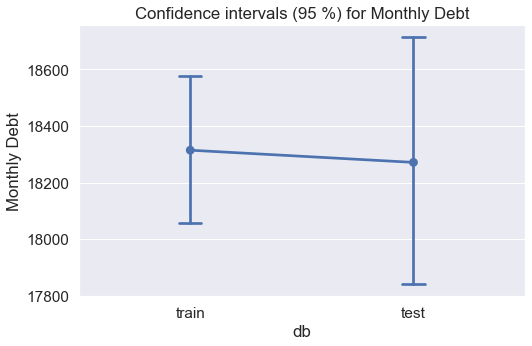

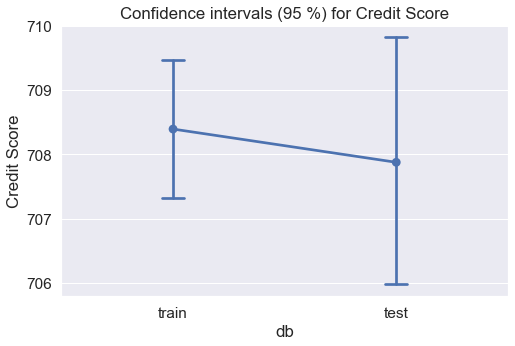

In [135]:
for vname in NUM_FEATURES:
    plt.figure(figsize=(8, 5))

    sns.pointplot(x='db', y=vname, data=X, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {vname}')
    plt.show()

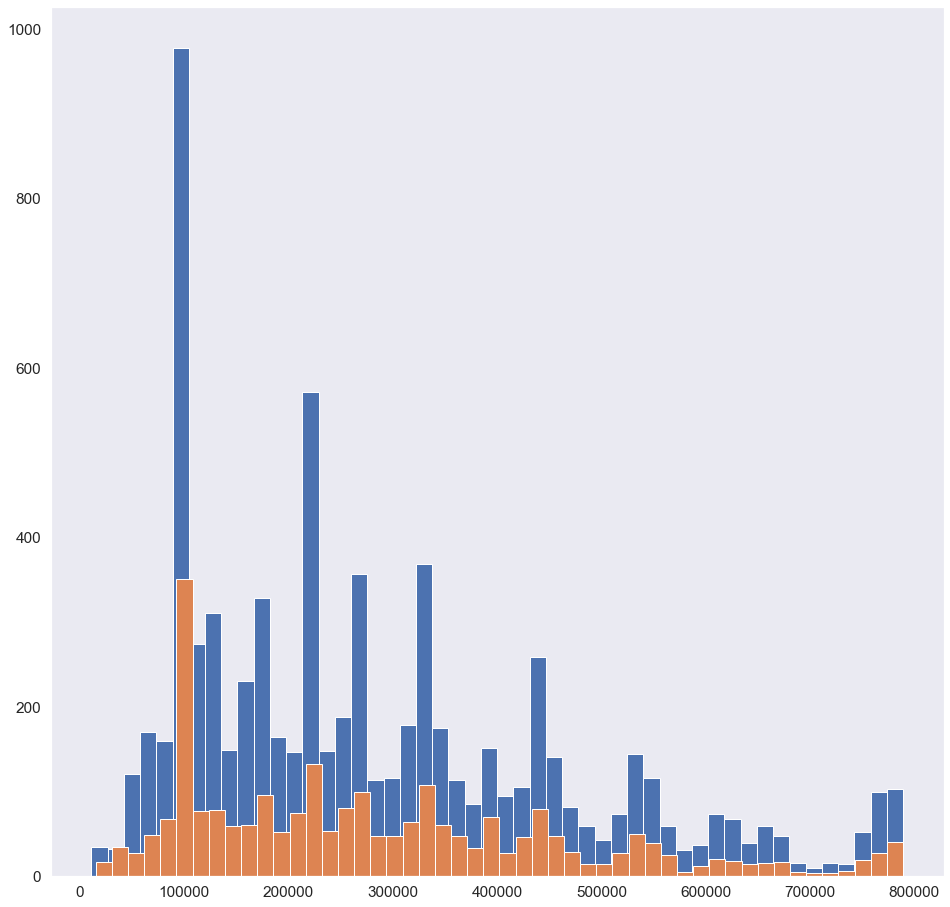

In [123]:
df['Current Loan Amount'].hist(figsize=(16,16), bins=50, grid=False)
df1['Current Loan Amount'].hist(figsize=(16,16), bins=50, grid=False)

С учетом доверительных интервалов можно сказать что распределение параметров на тестовой и тренировочной базе соотвествуют друг другу.

